In [5]:
import os
import sys
import time
from datetime import datetime as dt
import numpy as np
from matplotlib import pyplot as plt, ticker
from pysar.simulation.plot import *
from pysar.objects import timeseries, ifgramStack, sensor, gps
from pysar.utils import readfile, ptime, plot as pp, writefile, utils as ut

work_dir = '/Users/yunjunz/development/python/2018_ComputGeosci_PySAR/pysar_vs_gps'
os.chdir(work_dir)
print('Go to directory: '+work_dir)

site_r = 'GV01'

gps_dir = '/Users/yunjunz/insarlab/Galapagos/GPS'
pysar_dir = '/Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/GEOCODE'
pysar_dir = '/Users/yunjunz/insarlab/PYSAR_EXAMPLE/SierraNegraSenDT128/PYSAR/GEOCODE'

pysar_dir = '/Users/yunjunz/insarlab/Galapagos/GalapagosAlosAT133/PYSAR/GEOCODE'
head_angle = -12.873
head_ang = head_angle
ylim = None

ts_file = os.path.join(pysar_dir, 'geo_timeseries_ECMWF_demErr_refDate_plane.h5')
ts_obj = timeseries(ts_file)
ts_obj.open(print_msg=False)
atr = ts_obj.metadata

geom_file = os.path.join(pysar_dir, 'geo_geometryRadar.h5')
inc_angle = readfile.read(geom_file, datasetName='incidenceAngle')[0]
try:
    head_angle = readfile.read(geom_file, datasetName='headingAngle')[0]
except:
    head_angle = -12.873
    head_ang = head_angle

def read_timeseries(site, site_r=None):
    global inc_ang, head_ang, gps_obj, ts_obj
    ## Read GPS
    gps_obj = gps(site=site, data_dir=gps_dir)
    gps_obj.open(print_msg=False)
    
    y = ut.coord_geo2radar(gps_obj.site_lat, atr, 'lat')
    x = ut.coord_geo2radar(gps_obj.site_lon, atr, 'lon')
    inc_ang = inc_angle[y, x]
    if isinstance(head_ang, np.ndarray):
        head_ang = -1 * (180 + head_angle[y, x] + 90)
    print('lat={:.4f}, lon={:.4f}'.format(gps_obj.site_lat, gps_obj.site_lon))
    print('heading angle: {}'.format(head_ang))
    print('incidence angle: {}'.format(inc_ang))

    gps_times = gps_obj.times
    gps_dis = ut.enu2los(gps_obj.dis_e, gps_obj.dis_n, gps_obj.dis_u, heading_angle=head_ang, inc_angle=inc_ang)

    if site_r:
        gps_r_obj = gps(site=site_r, data_dir=gps_dir)
        gps_r_obj.open(print_msg=False)
        
        gps_times = sorted(list(set(gps_obj.times) & set(gps_r_obj.times)))
        dis_e = np.zeros(len(gps_times), np.float32)
        dis_n = np.zeros(dis_e.shape, np.float32)
        dis_u = np.zeros(dis_e.shape, np.float32)
        for i in range(len(gps_times)):
            idx1 = gps_obj.times.index(gps_times[i])
            idx2 = gps_r_obj.times.index(gps_times[i])
            dis_e[i] = gps_obj.dis_e[idx1] - gps_r_obj.dis_e[idx2]
            dis_n[i] = gps_obj.dis_n[idx1] - gps_r_obj.dis_n[idx2]
            dis_u[i] = gps_obj.dis_u[idx1] - gps_r_obj.dis_u[idx2]
        gps_dis = ut.enu2los(dis_e, dis_n, dis_u)

    ## Read InSAR
    box = (x, y, x+1, y+1)

    pysar_dis = ts_obj.read(box=box, print_msg=False)
    pysar_times = ts_obj.times

    if site_r:
        y_r = ut.coord_geo2radar(gps_r_obj.site_lat, atr, 'lat')
        x_r = ut.coord_geo2radar(gps_r_obj.site_lon, atr, 'lon')
        box_r = (x_r, y_r, x_r+1, y_r+1)
        pysar_dis -= ts_obj.read(box=box_r, print_msg=False)
    return gps_times, gps_dis, pysar_times, pysar_dis

## Plot
def plot_timeseries(site, gps_times, gps_dis, pysar_times, pysar_dis, site_r=None,
                    disp_fig=True, ylim=(-0.2, 1.5)):
    title = 'Site={}'.format(site)
    if site_r:
          title += ', Ref Site={}'.format(site_r)
    comm_idx = 2
    while comm_idx < len(pysar_times):
        if pysar_times[comm_idx] not in gps_times:
            comm_idx += 1
        else:
            break
    if comm_idx == len(pysar_times):
        raise RuntimeError('InSAR and GPS do not share ANY date.')

    comm_date = pysar_times[comm_idx]
    print('Common date: {}'.format(comm_date))
    pysar_dis -= pysar_dis[comm_idx]
    gps_dis -= gps_dis[gps_times.index(comm_date)]

    fig, ax = plt.subplots(figsize=(5, 3))
    ax.scatter(gps_times, gps_dis, s=0.5**2, label='GPS')
    ax.scatter(pysar_times, pysar_dis, s=8**2, facecolors='none', edgecolors=pp.mplColors[1], label='InSAR')
    ax = pp.auto_adjust_xaxis_date(ax, ts_obj.yearList)[0]
    ax.set_ylim(ylim)
    ax.set_xlabel('Time (year)', fontsize=font_size)
    ax.set_ylabel('LOS displacement (m)', fontsize=font_size)
    ax.set_title(title, fontsize=font_size)
    ax.tick_params(which='both', direction='in', labelsize=font_size,
                   bottom=True, top=True, left=True, right=True)
    ax.tick_params(labelsize=font_size, )
    ax.legend(loc='upper left')

    out_file = '{}'.format(site)
    if site_r:
        out_file += '-{}'.format(site_r)
    plt.savefig(out_file+'.jpg', bbox_inches='tight', transparent=True, dpi=fig_dpi)
    if disp_fig:
        plt.show()

Go to directory: /Users/yunjunz/development/python/2018_ComputGeosci_PySAR/pysar_vs_gps
reading incidenceAngle data from file: /Users/yunjunz/insarlab/Galapagos/GalapagosAlosAT133/PYSAR/GEOCODE/geo_geometryRadar.h5 ...


In [6]:
gps_sites = ['GV03', 'GV04', 'GV05', 'GV06', 'GV07', 'GV08', 'GV09', 'GV10']

for site in gps_sites:
    gps_times, gps_dis, pysar_times, pysar_dis = read_timeseries(site=site, site_r=site_r)
    plot_timeseries(site, gps_times, gps_dis, pysar_times, pysar_dis, site_r=site_r,
                    disp_fig=False, ylim=ylim)


calculating station lat/lon
reading time and displacement in east/north/vertical direction
lat=-0.7978, lon=-91.1329
heading angle: -12.873
incidence angle: 38.718563079833984
calculating station lat/lon
reading time and displacement in east/north/vertical direction
Common date: 2010-06-10 00:00:00
calculating station lat/lon
reading time and displacement in east/north/vertical direction
lat=-0.8115, lon=-91.1381
heading angle: -12.873
incidence angle: 38.66645050048828
calculating station lat/lon
reading time and displacement in east/north/vertical direction
Common date: 2010-06-10 00:00:00
calculating station lat/lon
reading time and displacement in east/north/vertical direction
lat=-0.8049, lon=-91.1212
heading angle: -12.873
incidence angle: 38.78563690185547
calculating station lat/lon
reading time and displacement in east/north/vertical direction
Common date: 2010-06-10 00:00:00
calculating station lat/lon
reading time and displacement in east/north/vertical direction
lat=-0.8343

Common date: 2015-03-07 00:00:00


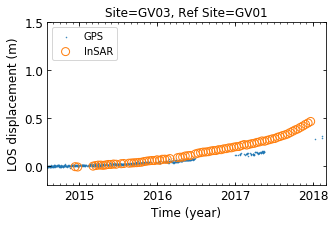

In [17]:
np.cos(-371 / 180. * np.pi)

0.9816271834476641

In [18]:
np.cos(-11 / 180. * np.pi)

0.981627183447664